In [165]:
import numpy as np
import pandas as pd
from numpy import linalg as la
from sklearn import datasets
import matplotlib
import matplotlib.pyplot as plt
import cvxopt
from cvxopt import matrix, solvers 
import seaborn as sns

In [166]:
mnist = datasets.load_digits()
X=mnist['data']
y=mnist['target']
X_train, X_test, y_train, y_test = X[:1348], X[1348:], y[:1348], y[1348:]
shuffle_index = np.random.permutation(1348)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
train_filter = np.where((y_train == 1 ) | (y_train == 7))
test_filter = np.where((y_test == 1) | (y_test == 7))
X_train, y_train = X_train[train_filter], y_train[train_filter]
X_test, y_test = X_test[test_filter], y_test[test_filter]
y_train[y_train == 7] = -1
y_test[y_test == 7] = -1

In [167]:
print('X_train')
print(X_train.shape)
print(X_train.dtype)
print('----------')
y_train = y_train.reshape(y_train.shape[0], 1)
y_train = y_train.astype(np.float64)
print('y_train')
print(y_train.shape)
print(y_train.dtype)
print('----------')
print('X_test')
print(X_test.shape)
print(X_test.dtype)
print('----------')
y_test = y_test.reshape(y_test.shape[0], 1)
y_test = y_test.astype(np.float64)
print('y_test')
print(y_test.shape)
print(y_test.dtype)
print('----------')

X_train
(270, 64)
float64
----------
y_train
(270, 1)
float64
----------
X_test
(91, 64)
float64
----------
y_test
(91, 1)
float64
----------


In [168]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

In [169]:
class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None: self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Gram matrix
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        # solve QP problem
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        # Lagrange multipliers
        a = np.ravel(solution['x'])

        # Support vectors have non zero lagrange multipliers
        sv = a > 1e-5
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]
        print("%d support vectors out of %d points" % (len(self.a), n_samples))

        # Intercept
        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        # Weight vector
        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None
        print('The value of C is:', self.C)

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b
    def predict(self, X):
        return np.sign(self.project(X))


In [170]:
if __name__ == "__main__":
    import matplotlib.pyplot as pl

    
              
    def test_linear(C):
        clf = SVM(C=C)
        clf.fit(X_train, y_train)
        y_predict = clf.predict(X_test)
        loss = 0
        correct = 0
        true_positives = 0
        true_negatives = 0
        false_positives = 0
        false_negatives = 0
        for x in range(X_test.shape[0]):
            if y_predict[x] == y_test[x]:
                correct = correct + 1
            else:
                loss = loss + 1
            if y_test[x] == 1:
                if y_predict[x] == 1:
                    true_positives += 1
                else:
                    false_positives += 1
            if y_test[x] == -1:
                if y_predict[x] == -1:
                    true_negatives += 1
                else:
                    false_negatives += 1

        cf_matrix = np.array([[true_positives, false_positives], [false_negatives, true_negatives]])
        plt.figure(figsize=(10, 10))
        cm = [[327, 237], [289, 200]]
        ax = sns.heatmap(cf_matrix, cmap=sns.color_palette(['tomato', 'lightgreen'], as_cmap=True),
                 annot=[[f"True One = {cf_matrix[0][0]:.0f}", f"False One = {cf_matrix[0][1]:.0f}"], [f"False Seven = {cf_matrix[1][0]:.0f}", f"True Seven = {cf_matrix[1][1]:.0f}"]],
                 fmt='', annot_kws={'fontsize': 30}, cbar=False, square=True)

        print("The validation loss is: ", loss, "out of ", X_test.shape[0], "or ", loss/X_test.shape[0])
        #print("The margin is: ", bias2 - bias1)
        


    

     pcost       dcost       gap    pres   dres
 0: -3.8677e+00 -3.5742e+00  9e+02  3e+01  1e-12
 1: -1.3385e-01 -3.5185e+00  2e+01  4e-01  1e-12
 2: -6.5980e-02 -1.7819e+00  3e+00  5e-02  2e-13
 3: -1.8316e-02 -4.3433e-01  6e-01  1e-02  4e-14
 4: -4.6165e-03 -5.0773e-02  6e-02  7e-04  7e-15
 5: -5.7900e-03 -1.3816e-02  9e-03  1e-04  3e-15
 6: -7.2089e-03 -9.1330e-03  2e-03  1e-05  3e-15
 7: -7.7668e-03 -8.0433e-03  3e-04  6e-07  3e-15
 8: -7.8728e-03 -7.8940e-03  2e-05  5e-08  3e-15
 9: -7.8818e-03 -7.8821e-03  3e-07  6e-10  3e-15
10: -7.8819e-03 -7.8819e-03  3e-09  6e-12  3e-15
Optimal solution found.
18 support vectors out of 270 points
The value of C is: 0.01
The validation loss is:  6 out of  91 or  0.06593406593406594


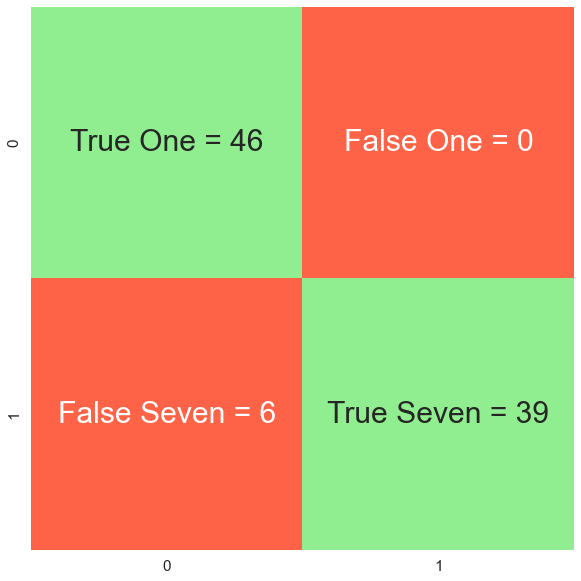

In [171]:
test_linear(0.01)


     pcost       dcost       gap    pres   dres
 0: -4.7830e+00 -8.5548e+01  1e+03  7e+00  1e-12
 1: -1.6810e+00 -6.1773e+01  1e+02  5e-01  1e-12
 2: -3.8317e-01 -1.3309e+01  2e+01  7e-02  4e-13
 3: -2.7140e-02 -1.5531e+00  2e+00  7e-03  1e-13
 4: -5.7444e-03 -2.1662e-01  3e-01  8e-04  3e-14
 5: -3.4188e-03 -1.4389e-02  1e-02  8e-06  7e-15
 6: -6.0806e-03 -9.0161e-03  3e-03  2e-06  4e-15
 7: -7.4520e-03 -8.3115e-03  9e-04  2e-07  4e-15
 8: -7.8626e-03 -7.8984e-03  4e-05  5e-09  4e-15
 9: -7.8815e-03 -7.8823e-03  8e-07  6e-11  4e-15
10: -7.8819e-03 -7.8819e-03  1e-08  8e-13  5e-15
Optimal solution found.
18 support vectors out of 270 points
The value of C is: 0.25
The validation loss is:  6 out of  91 or  0.06593406593406594


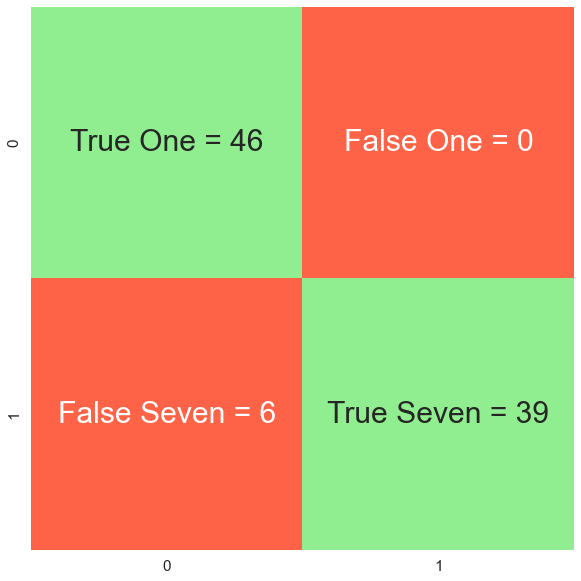

In [161]:
test_linear(0.25)

     pcost       dcost       gap    pres   dres
 0: -5.7349e+00 -1.7830e+02  1e+03  4e+00  2e-12
 1: -2.6897e+00 -1.0254e+02  2e+02  3e-01  2e-12
 2: -4.8993e-01 -1.9955e+01  3e+01  5e-02  8e-13
 3: -2.9618e-02 -1.6828e+00  2e+00  4e-03  2e-13
 4: -4.5177e-03 -2.2924e-01  3e-01  4e-04  4e-14
 5: -2.5532e-03 -1.6152e-02  1e-02  4e-06  7e-15
 6: -5.7614e-03 -9.1964e-03  4e-03  9e-07  4e-15
 7: -7.3188e-03 -8.3519e-03  1e-03  2e-07  4e-15
 8: -7.8309e-03 -7.9305e-03  1e-04  6e-09  4e-15
 9: -7.8796e-03 -7.8840e-03  4e-06  2e-10  4e-15
10: -7.8819e-03 -7.8820e-03  7e-08  3e-12  4e-15
Optimal solution found.
18 support vectors out of 270 points
The value of C is: 0.5
The validation loss is:  6 out of  91 or  0.06593406593406594


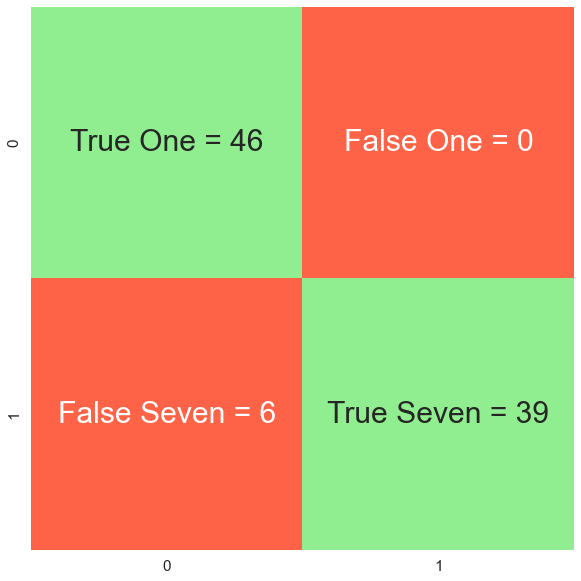

In [162]:
test_linear(0.5)

     pcost       dcost       gap    pres   dres
 0: -6.6853e+00 -2.7826e+02  2e+03  3e+00  2e-12
 1: -3.3403e+00 -1.3422e+02  2e+02  2e-01  2e-12
 2: -5.4160e-01 -2.4876e+01  4e+01  4e-02  1e-12
 3: -3.0036e-02 -1.8923e+00  3e+00  3e-03  2e-13
 4: -2.5409e-03 -2.4547e-01  3e-01  3e-04  3e-14
 5: -1.6470e-03 -1.7955e-02  2e-02  3e-06  7e-15
 6: -5.4636e-03 -9.4370e-03  4e-03  6e-07  4e-15
 7: -7.1632e-03 -8.4191e-03  1e-03  1e-07  4e-15
 8: -7.7758e-03 -7.9922e-03  2e-04  7e-09  4e-15
 9: -7.8736e-03 -7.8901e-03  2e-05  5e-10  4e-15
10: -7.8818e-03 -7.8821e-03  3e-07  8e-12  4e-15
11: -7.8819e-03 -7.8819e-03  3e-09  8e-14  4e-15
Optimal solution found.
18 support vectors out of 270 points
The value of C is: 0.75
The validation loss is:  6 out of  91 or  0.06593406593406594


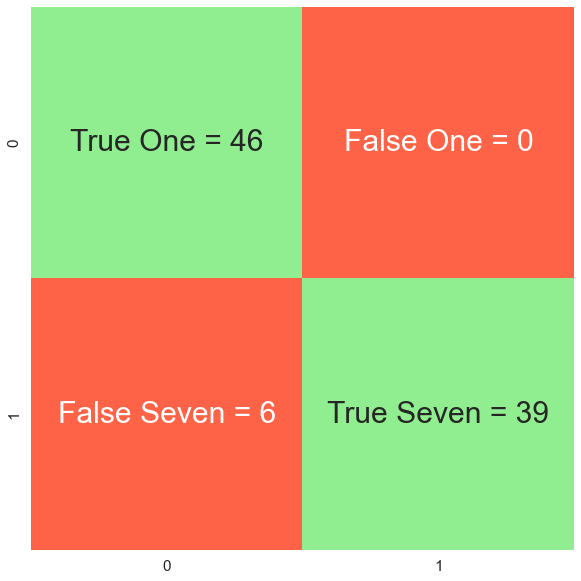

In [163]:
test_linear(0.75)

     pcost       dcost       gap    pres   dres
 0: -7.6340e+00 -3.8543e+02  2e+03  2e+00  2e-12
 1: -3.7738e+00 -1.6085e+02  3e+02  2e-01  2e-12
 2: -4.9746e-01 -2.5846e+01  4e+01  3e-02  1e-12
 3: -2.4267e-02 -1.9910e+00  3e+00  2e-03  2e-13
 4:  3.5942e-04 -2.5247e-01  4e-01  2e-04  3e-14
 5: -9.4544e-04 -1.9152e-02  2e-02  2e-06  7e-15
 6: -5.2695e-03 -9.5683e-03  4e-03  4e-07  4e-15
 7: -7.0827e-03 -8.4373e-03  1e-03  9e-08  4e-15
 8: -7.7480e-03 -8.0284e-03  3e-04  5e-09  4e-15
 9: -7.8698e-03 -7.8946e-03  2e-05  4e-10  4e-15
10: -7.8817e-03 -7.8821e-03  4e-07  5e-12  4e-15
11: -7.8819e-03 -7.8819e-03  4e-09  6e-14  4e-15
Optimal solution found.
18 support vectors out of 270 points
The value of C is: 1.0
The validation loss is:  6 out of  91 or  0.06593406593406594


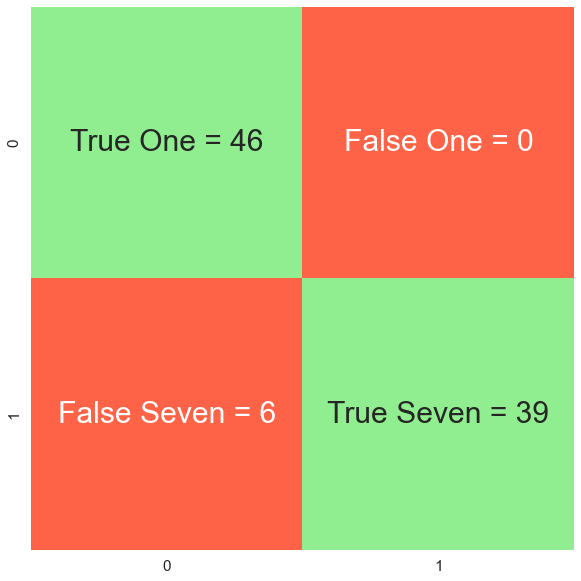

In [164]:
test_linear(1)